In [41]:
# importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from scipy import stats
from imblearn.over_sampling import SMOTE


In [3]:
# Load dataset
df = pd.read_csv("Ecommerce_customer.csv")

In [4]:
# taking samples
df = df.sample(n=5000, random_state=42)

In [42]:
# Handle missing values with median
df.fillna(df.median(), inplace=True)

# Outlier Removal using Z-score 
numeric_columns = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(stats.zscore(df[numeric_columns]))
df = df[(z_scores < 3).all(axis=1)]  # Keep only values with Z-score less than 3

# Handling imbalanced data using SMOTE 
X = df[features]
y = df[target]
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X, y)




C:\Users\simis\anaconda3\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [8]:
# Encoding categorical variables
label_encoders = {}
for col in ['department', 'product_name']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [9]:
# selecting features 
features = ['order_dow', 'order_hour_of_day', 'days_since_prior_order', 'department_id', 'product_id', 'add_to_cart_order']
target = 'reordered'


In [11]:
# Normalize features using MinMax
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


In [17]:
# Checking if there are NaN or infinite values in the dataset
if df[features].isna().sum().sum() > 0:
    print("There are NaN values in the features.")
if np.any(np.isinf(df[features].values)):
    print("There are infinite values in the features.")
if np.any(np.isnan(df[target].values)):
    print("There are NaN values in the target variable.")


In [18]:
# Replace NaN in the target with 0 if necessary
y = np.nan_to_num(df[target].values, nan=0)


In [19]:
def create_sequences(data, target, sequence_length=10):
    X, y_seq = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y_seq.append(target[i+sequence_length])
    return np.array(X), np.array(y_seq)

sequence_length = 10
X, y = create_sequences(df[features].values, y, sequence_length)

In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
#  Implementation of LSTM Model
model_lstm = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                   loss='binary_crossentropy', metrics=['accuracy'])

model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2)



Epoch 1/10
125/125 - 4s - 29ms/step - accuracy: 0.6017 - loss: 0.6847 - val_accuracy: 0.5942 - val_loss: 0.6796
Epoch 2/10
125/125 - 1s - 8ms/step - accuracy: 0.6022 - loss: 0.6741 - val_accuracy: 0.5942 - val_loss: 0.6758
Epoch 3/10
125/125 - 1s - 8ms/step - accuracy: 0.6022 - loss: 0.6722 - val_accuracy: 0.5942 - val_loss: 0.6759
Epoch 4/10
125/125 - 1s - 7ms/step - accuracy: 0.6022 - loss: 0.6722 - val_accuracy: 0.5942 - val_loss: 0.6760
Epoch 5/10
125/125 - 1s - 9ms/step - accuracy: 0.6022 - loss: 0.6725 - val_accuracy: 0.5942 - val_loss: 0.6757
Epoch 6/10
125/125 - 1s - 8ms/step - accuracy: 0.6022 - loss: 0.6723 - val_accuracy: 0.5942 - val_loss: 0.6760
Epoch 7/10
125/125 - 1s - 8ms/step - accuracy: 0.6022 - loss: 0.6721 - val_accuracy: 0.5942 - val_loss: 0.6758
Epoch 8/10
125/125 - 1s - 6ms/step - accuracy: 0.6022 - loss: 0.6721 - val_accuracy: 0.5942 - val_loss: 0.6758
Epoch 9/10
125/125 - 1s - 7ms/step - accuracy: 0.6022 - loss: 0.6721 - val_accuracy: 0.5942 - val_loss: 0.6761


In [23]:
# XGBoost Model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgb_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predictions
lstm_preds = model_lstm.predict(X_test)
xgb_preds = xgb_model.predict(X_test.reshape(X_test.shape[0], -1))


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 


In [24]:
# Ensemble Approach
ensemble_preds = (lstm_preds.flatten() + xgb_preds) / 2
ensemble_preds = np.round(ensemble_preds)


In [25]:
# Evaluation
print("LSTM MAE:", mean_absolute_error(y_test, lstm_preds))
print("XGBoost MAE:", mean_absolute_error(y_test, xgb_preds))
print("Ensemble MAE:", mean_absolute_error(y_test, ensemble_preds))


LSTM MAE: 0.48064476251602173
XGBoost MAE: 0.4468937875751503
Ensemble MAE: 0.4468937875751503


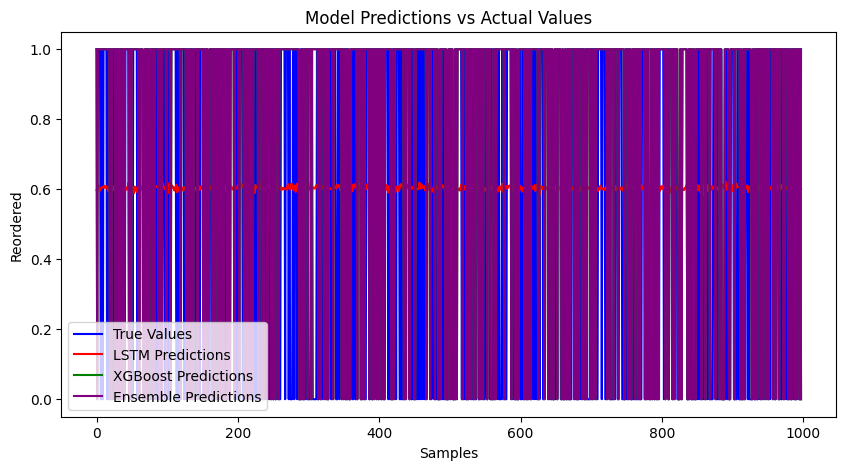

In [26]:
# Plot Results (Optional)
plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='True Values', color='blue')
plt.plot(range(len(lstm_preds)), lstm_preds.flatten(), label='LSTM Predictions', color='red')
plt.plot(range(len(xgb_preds)), xgb_preds, label='XGBoost Predictions', color='green')
plt.plot(range(len(ensemble_preds)), ensemble_preds, label='Ensemble Predictions', color='purple')
plt.legend()
plt.title("Model Predictions vs Actual Values")
plt.xlabel("Samples")
plt.ylabel("Reordered")
plt.show()

In [43]:
# After analysing the results, hyper parameter tuning
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# LSTM Model with tuning parameters
def create_lstm_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        LSTM(units, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        LSTM(units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Example grid search for tuning LSTM model parameters (units, dropout_rate, learning_rate)
# You can use GridSearchCV or a custom loop for finer control over hyperparameter tuning
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005]
}

# Custom function to fit the model
def lstm_model_fit(units, dropout_rate, learning_rate):
    model = create_lstm_model(units=units, dropout_rate=dropout_rate, learning_rate=learning_rate)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), 
              callbacks=[early_stopping], verbose=1)
    return model

# Example of tuning
for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            print(f"Training with units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}")
            lstm_model_fit(units, dropout_rate, learning_rate)

# Final evaluation of the best model (already trained using early stopping)
lstm_preds = model_lstm.predict(X_test)
lstm_mae = mean_absolute_error(y_test, lstm_preds)
print(f"LSTM MAE: {lstm_mae}")


Training with units=50, dropout_rate=0.2, learning_rate=0.001
Epoch 1/20


C:\Users\simis\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5839 - loss: 0.6801 - val_accuracy: 0.5942 - val_loss: 0.6798
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5887 - loss: 0.6785 - val_accuracy: 0.5942 - val_loss: 0.6767
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6189 - loss: 0.6647 - val_accuracy: 0.5942 - val_loss: 0.6761
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5922 - loss: 0.6758 - val_accuracy: 0.5942 - val_loss: 0.6805
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5982 - loss: 0.6746 - val_accuracy: 0.5942 - val_loss: 0.6761
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6047 - loss: 0.6719 - val_accuracy: 0.5942 - val_loss: 0.6773
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5996 - loss: 0.6734 - val_accuracy: 0.5942 - val_loss: 0.6775
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5997 - loss: 0.6739 - val_accuracy: 0.5942 - val

In [44]:
# After the Evaluation of result, performing tuning again
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# XGBoost hyperparameter tuning
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Hyperparameter grid
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Best parameters
print(f"Best parameters found: {grid_search.best_params_}")

# Train the model using the best parameters
best_xgb_model = grid_search.best_estimator_

# Evaluate the model on the test set
xgb_preds = best_xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f"XGBoost MAE: {xgb_mae}")


Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}
XGBoost MAE: 0.40681362725450904


In [29]:
from sklearn.linear_model import LogisticRegression

# Ensemble model: Stacking approach
# Train a logistic regression on top of LSTM and XGBoost predictions
lstm_preds_train = model_lstm.predict(X_train)
xgb_preds_train = best_xgb_model.predict(X_train.reshape(X_train.shape[0], -1))

# Stack the predictions and train a logistic regression to combine the outputs
stacked_predictions_train = np.column_stack((lstm_preds_train, xgb_preds_train))
ensemble_model = LogisticRegression()
ensemble_model.fit(stacked_predictions_train, y_train)

# Predict using the ensemble model
lstm_preds_test = model_lstm.predict(X_test)
xgb_preds_test = best_xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
stacked_predictions_test = np.column_stack((lstm_preds_test, xgb_preds_test))

ensemble_preds = ensemble_model.predict(stacked_predictions_test)

# Evaluate the ensemble model
ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
print(f"Ensemble MAE: {ensemble_mae}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Ensemble MAE: 0.40681362725450904


In [45]:
from sklearn.metrics import mean_squared_error, r2_score

# LSTM Evaluation
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, lstm_preds)
print(f"LSTM MSE: {lstm_mse}, RMSE: {lstm_rmse}, R-squared: {lstm_r2}")

# XGBoost Evaluation
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_preds)
print(f"XGBoost MSE: {xgb_mse}, RMSE: {xgb_rmse}, R-squared: {xgb_r2}")

# Ensemble Evaluation
ensemble_mse = mean_squared_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test, ensemble_preds)
print(f"Ensemble MSE: {ensemble_mse}, RMSE: {ensemble_rmse}, R-squared: {ensemble_r2}")


LSTM MSE: 0.2414369136095047, RMSE: 0.4913623038141049, R-squared: -0.0012787580490112305
XGBoost MSE: 0.40681362725450904, RMSE: 0.6378194315435278, R-squared: -0.6871234359711034
Ensemble MSE: 0.405811623246493, RMSE: 0.6370334553588948, R-squared: -0.6829679595278246


In [46]:
# Adding additional features (e.g., time-based features or rolling means)
df['order_dow_sin'] = np.sin(2 * np.pi * df['order_dow'] / 7)
df['order_dow_cos'] = np.cos(2 * np.pi * df['order_dow'] / 7)
df['order_hour_of_day_sin'] = np.sin(2 * np.pi * df['order_hour_of_day'] / 24)
df['order_hour_of_day_cos'] = np.cos(2 * np.pi * df['order_hour_of_day'] / 24)

# Rolling averages (if applicable)
df['days_since_prior_order_rollmean'] = df['days_since_prior_order'].rolling(window=7).mean()

# Selecting important features
features = ['order_dow_sin', 'order_dow_cos', 'order_hour_of_day_sin', 'order_hour_of_day_cos', 
            'days_since_prior_order_rollmean', 'department_id', 'product_id', 'add_to_cart_order']
target = 'reordered'

# Normalize features
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


In [47]:
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), 
                       activation='relu', return_sequences=True, 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

# Initialize KerasTuner RandomSearch
tuner = RandomSearch(
    LSTMHyperModel(),
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='lstm_tuning',
    project_name='reorder_prediction')

# Perform the search
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get the best model
best_model_lstm = tuner.get_best_models(1)[0]


Reloading Tuner from lstm_tuning\reorder_prediction\tuner0.json


C:\Users\simis\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\simis\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [48]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# Create XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Get the best model
best_xgb_model = random_search.best_estimator_



In [49]:
# LSTM model evaluation
lstm_preds = best_model_lstm.predict(X_test)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_rmse = np.sqrt(lstm_mse)
lstm_r2 = r2_score(y_test, lstm_preds)

# XGBoost model evaluation
xgb_preds = best_xgb_model.predict(X_test.reshape(X_test.shape[0], -1))
xgb_mse = mean_squared_error(y_test, xgb_preds)
xgb_rmse = np.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_preds)

# Ensemble evaluation
ensemble_preds = (lstm_preds.flatten() + xgb_preds) / 2
ensemble_preds = np.round(ensemble_preds)

ensemble_mse = mean_squared_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test, ensemble_preds)

# Print new evaluation results
print(f"LSTM MSE: {lstm_mse}, RMSE: {lstm_rmse}, R-squared: {lstm_r2}")
print(f"XGBoost MSE: {xgb_mse}, RMSE: {xgb_rmse}, R-squared: {xgb_r2}")
print(f"Ensemble MSE: {ensemble_mse}, RMSE: {ensemble_rmse}, R-squared: {ensemble_r2}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step  
LSTM MSE: 0.24149858951568604, RMSE: 0.49142505991828095, R-squared: -0.001534581184387207
XGBoost MSE: 0.405811623246493, RMSE: 0.6370334553588948, R-squared: -0.6829679595278246
Ensemble MSE: 0.405811623246493, RMSE: 0.6370334553588948, R-squared: -0.6829679595278246


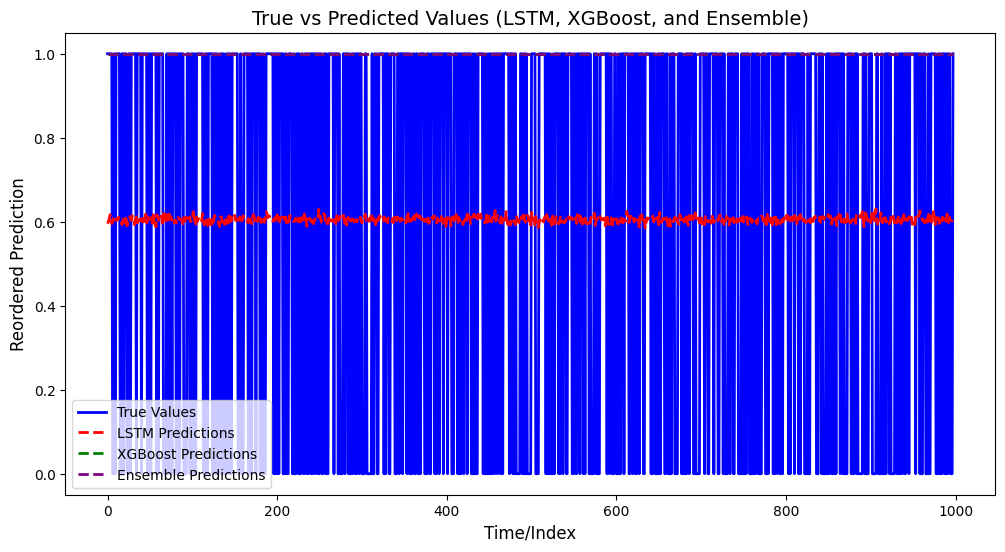

In [50]:
import matplotlib.pyplot as plt

# Assuming you already have the true values (y_test) and predictions (lstm_preds, xgb_preds, ensemble_preds)

# Plot true vs predicted values
plt.figure(figsize=(12, 6))

# Plot True values
plt.plot(y_test, label="True Values", color='blue', linewidth=2)

# Plot LSTM predictions
plt.plot(lstm_preds, label="LSTM Predictions", color='red', linestyle='--', linewidth=2)

# Plot XGBoost predictions
plt.plot(xgb_preds, label="XGBoost Predictions", color='green', linestyle='--', linewidth=2)

# Plot Ensemble predictions
plt.plot(ensemble_preds, label="Ensemble Predictions", color='purple', linestyle='--', linewidth=2)

# Adding title and labels
plt.title("True vs Predicted Values (LSTM, XGBoost, and Ensemble)", fontsize=14)
plt.xlabel("Time/Index", fontsize=12)
plt.ylabel("Reordered Prediction", fontsize=12)

# Adding a legend
plt.legend()

# Show the plot
plt.show()
